# Predicting Extreme Rare Events
* Paper Mill Sheet Breaks

## Build a Rare Event Classifier - using an Autoencoder with Dense Layers

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pylab import rcParams

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

### A dataset representing Rare Events has far fewer positively-labeled data points than negatively-labeled
* They may represent about 5-10 % of the total data points

### With Extreme Rare Events, this data represents less than 1 % of the total data
* Examples of this type of problem include: sheet breaks, manufacturing errors, online purchasing clicks
* The small amount of positively-labeled data makes deep learning approaches difficult
* An autoencoder approaches the problem in a similar fashion as anomaly detection

In [2]:
from numpy.random import seed
seed(1)

SEED = 123 #used to help randomly select the data points

DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6

LABELS = ["Normal","Break"]

## Load Data
### Data on pulp-and-paper mill Sheet Breaks
* Nearly 18,000 observations - collected over 15 days
* Target column, y - binary, 1 = sheet break
* Nearly 124 positively labeled samples - about 0.6 %

In [3]:
df = pd.read_csv('../../Downloads/processminer-rare-event-mts - data.csv')

In [4]:
df.describe

<bound method NDFrame.describe of                 time  y        x1        x2        x3          x4        x5  \
0        5/1/99 0:00  0  0.376665 -4.596435 -4.095756   13.497687 -0.118830   
1        5/1/99 0:02  0  0.475720 -4.542502 -4.018359   16.230659 -0.128733   
2        5/1/99 0:04  0  0.363848 -4.681394 -4.353147   14.127998 -0.138636   
3        5/1/99 0:06  0  0.301590 -4.758934 -4.023612   13.161567 -0.148142   
4        5/1/99 0:08  0  0.265578 -4.749928 -4.333150   15.267340 -0.155314   
5        5/1/99 0:10  0  0.381253 -4.611746 -4.085072   14.143195 -0.162501   
6        5/1/99 0:12  0  0.313325 -4.530210 -4.120931   18.681465 -0.169672   
7        5/1/99 0:14  0  0.396401 -4.699047 -4.074193   21.307655 -0.176859   
8        5/1/99 0:16  0  0.342688 -4.553506 -4.188885   22.892036 -0.184046   
9        5/1/99 0:18  0  0.458252 -4.639561 -4.246547   23.160957 -0.191218   
10       5/1/99 0:20  0  0.393756 -4.811998 -4.116455   27.550848 -0.198405   
11       5/1/99 0:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18398 entries, 0 to 18397
Data columns (total 63 columns):
time    18398 non-null object
y       18398 non-null int64
x1      18398 non-null float64
x2      18398 non-null float64
x3      18398 non-null float64
x4      18398 non-null float64
x5      18398 non-null float64
x6      18398 non-null float64
x7      18398 non-null float64
x8      18398 non-null float64
x9      18398 non-null float64
x10     18398 non-null float64
x11     18398 non-null float64
x12     18398 non-null float64
x13     18398 non-null float64
x14     18398 non-null float64
x15     18398 non-null float64
x16     18398 non-null float64
x17     18398 non-null float64
x18     18398 non-null float64
x19     18398 non-null float64
x20     18398 non-null float64
x21     18398 non-null float64
x22     18398 non-null float64
x23     18398 non-null float64
x24     18398 non-null float64
x25     18398 non-null float64
x26     18398 non-null float64
x27     18398 non-null flo

## Preprare Data
### Objective is predicting sheet breaks (rare event)
* Want to predict breaks 4 minutes in advance
* With this time-series dataset, shifting the labels by 2 rows corresponds to 4 minutes

### Create a Function for Shifting
* For rows where n is positively labeled (indicating a break)
* Make preceding 2 rows (n-2 and n-1), equal to 1
    * So the classifier can learn 4 minutes ahead
* Delete row n
    * Desired predictions are 4 minutes prior

In [6]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    vector = df['y'].copy()
    
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
        
    labelcol = 'y'
    
    # Add vector to the df
    
    df.insert(loc = 0, column = labelcol+'tmp', value = vector)
    
    # delete row n (rows where labelcol == 1)
    
    df = df.drop(df[df[labelcol] == 1].index)
    
    # Drop labelcol and rename the tmp col as labelcol
    
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    
    # Make the labelcol binary
    
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

* Function shifts the binary labels of the DataFrame
    * by the amount indicated as the shift (number of rows)

### Remove the Categorical Columns, & the 'time' column

In [7]:
df = df.drop(['time', 'x28', 'x61'], axis = 1)

### Split Data into Training, Validation, and Test sets
* a subset (negatively labeled data - 0s) will be used for training the Autoencoder

In [8]:
df_train, df_test = train_test_split(df, test_size = DATA_SPLIT_PCT, random_state = SEED)

df_train, df_valid = train_test_split(df_train, test_size = DATA_SPLIT_PCT, random_state = SEED)

df_train_0 = df_train.loc[df['y'] == 0]
df_train_1 = df_train.loc[df['y'] == 1]
df_train_0_x = df_train_0.drop(['y'], axis=1)
df_train_1_x = df_train_1.drop(['y'], axis=1)

df_valid_0 = df_valid.loc[df['y'] == 0]
df_valid_1 = df_valid.loc[df['y'] == 1]
df_valid_0_x = df_valid_0.drop(['y'], axis=1)
df_valid_1_x = df_valid_1.drop(['y'], axis=1)

df_test_0 = df_test.loc[df['y'] == 0]
df_test_1 = df_test.loc[df['y'] == 1]
df_test_0_x = df_test_0.drop(['y'], axis=1)
df_test_1_x = df_test_1.drop(['y'], axis=1)

### Standardize Data
* Gaussian transformation - mean=0, variance=1

In [9]:
scaler = StandardScaler().fit(df_train_0_x)

df_train_0_x_rescaled = scaler.transform(df_train_0_x)

df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['y'], axis = 1))

df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['y'], axis = 1))

# Build the Autoencoder Classifier
* Consists of 2 modules
    * Encoder - processes data to understand underlying features
    * Decoder - restores original data from this processed data
* Treats the majority, negatively-labeled data as *normal*
* Model is trained on this data, and Reconstruction Error is small with this data
* However, reconstructing data with Extreme Rare Events would produce high errors at these data points

### Initialize the model architecture
* a simple model with Dense layers
* input_dim - # of predictor variables

In [15]:
nb_epoch = 200

batch_size = 128

input_dim = df_train_0_x_rescaled.shape[1] 

encoding_dim = 32

hidden_dim = int(encoding_dim / 2)

learning_rate = 1e-3


input_layer = Input(shape = (input_dim, ))

encoder = Dense(encoding_dim, activation = "relu",
                activity_regularizer = regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation = "relu")(encoder)

decoder = Dense(hidden_dim, activation = "relu")(encoder)
decoder = Dense(encoding_dim, activation = "relu")(decoder)
decoder = Dense(input_dim, activation = "linear")(decoder)

autoencoder = Model(inputs = input_layer, outputs = decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 59)]              0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1920      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_9 (Dense)              (None, 59)                1947      
Total params: 5,211
Trainable params: 5,211
Non-trainable params: 0
___________________________________________________________

### Train Model
* Save the trained model to a file

In [18]:
autoencoder.compile(metrics = ['accuracy'],
                    loss = 'mean_squared_error',
                    optimizer = 'adam')

cp = ModelCheckpoint(filepath = "autoencoder_classifier.h5",
                               save_best_only = True,
                               verbose = 0)

tb = TensorBoard(log_dir = './logs',
                histogram_freq = 0,
                write_graph = True,
                write_images = True)

history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled,
                    epochs = nb_epoch,
                    batch_size = batch_size,
                    shuffle = True,
                    validation_data = (df_valid_0_x_rescaled, df_valid_0_x_rescaled),
                    verbose = 1,
                    callbacks = [cp, tb]).history

Train on 11697 samples, validate on 2926 samples
Epoch 1/200
11697/11697 [==============================] - 1s 62us/sample - loss: 0.8986 - accuracy: 0.0582 - val_loss: 0.6926 - val_accuracy: 0.1138
Epoch 2/200
11697/11697 [==============================] - 0s 21us/sample - loss: 0.5187 - accuracy: 0.1410 - val_loss: 0.4871 - val_accuracy: 0.1787
Epoch 3/200
11697/11697 [==============================] - 0s 20us/sample - loss: 0.3971 - accuracy: 0.2283 - val_loss: 0.4092 - val_accuracy: 0.2519
Epoch 4/200
11697/11697 [==============================] - 0s 20us/sample - loss: 0.3449 - accuracy: 0.2883 - val_loss: 0.3622 - val_accuracy: 0.3175
Epoch 5/200
11697/11697 [==============================] - 0s 21us/sample - loss: 0.3112 - accuracy: 0.3422 - val_loss: 0.3315 - val_accuracy: 0.3346
Epoch 6/200
11697/11697 [==============================] - 0s 20us/sample - loss: 0.2883 - accuracy: 0.3674 - val_loss: 0.3109 - val_accuracy: 0.3599
Epoch 7/200
11697/11697 [==========================

Epoch 55/200
11697/11697 [==============================] - 0s 19us/sample - loss: 0.1284 - accuracy: 0.5578 - val_loss: 0.1492 - val_accuracy: 0.5461
Epoch 56/200
11697/11697 [==============================] - 0s 20us/sample - loss: 0.1276 - accuracy: 0.5585 - val_loss: 0.1487 - val_accuracy: 0.5362
Epoch 57/200
11697/11697 [==============================] - 0s 22us/sample - loss: 0.1268 - accuracy: 0.5589 - val_loss: 0.1476 - val_accuracy: 0.5448
Epoch 58/200
11697/11697 [==============================] - 0s 20us/sample - loss: 0.1262 - accuracy: 0.5558 - val_loss: 0.1470 - val_accuracy: 0.5472
Epoch 59/200
11697/11697 [==============================] - 0s 20us/sample - loss: 0.1255 - accuracy: 0.5591 - val_loss: 0.1469 - val_accuracy: 0.5519
Epoch 60/200
11697/11697 [==============================] - 0s 20us/sample - loss: 0.1248 - accuracy: 0.5589 - val_loss: 0.1460 - val_accuracy: 0.5663
Epoch 61/200
11697/11697 [==============================] - 0s 21us/sample - loss: 0.1241 - ac

11697/11697 [==============================] - 0s 24us/sample - loss: 0.1059 - accuracy: 0.5946 - val_loss: 0.1256 - val_accuracy: 0.5954
Epoch 110/200
11697/11697 [==============================] - 0s 22us/sample - loss: 0.1057 - accuracy: 0.6005 - val_loss: 0.1250 - val_accuracy: 0.5906
Epoch 111/200
11697/11697 [==============================] - 0s 18us/sample - loss: 0.1054 - accuracy: 0.5983 - val_loss: 0.1261 - val_accuracy: 0.5988
Epoch 112/200
11697/11697 [==============================] - 0s 22us/sample - loss: 0.1054 - accuracy: 0.5984 - val_loss: 0.1243 - val_accuracy: 0.5954
Epoch 113/200
11697/11697 [==============================] - 0s 22us/sample - loss: 0.1052 - accuracy: 0.5958 - val_loss: 0.1241 - val_accuracy: 0.5957
Epoch 114/200
11697/11697 [==============================] - 0s 20us/sample - loss: 0.1050 - accuracy: 0.5986 - val_loss: 0.1248 - val_accuracy: 0.6008
Epoch 115/200
11697/11697 [==============================] - 0s 20us/sample - loss: 0.1048 - accuracy:

Epoch 163/200
11697/11697 [==============================] - 0s 18us/sample - loss: 0.0984 - accuracy: 0.6006 - val_loss: 0.1184 - val_accuracy: 0.6029
Epoch 164/200
11697/11697 [==============================] - 0s 20us/sample - loss: 0.0984 - accuracy: 0.6005 - val_loss: 0.1175 - val_accuracy: 0.6056
Epoch 165/200
11697/11697 [==============================] - 0s 20us/sample - loss: 0.0981 - accuracy: 0.6021 - val_loss: 0.1172 - val_accuracy: 0.6083
Epoch 166/200
11697/11697 [==============================] - 0s 17us/sample - loss: 0.0980 - accuracy: 0.6031 - val_loss: 0.1182 - val_accuracy: 0.6077
Epoch 167/200
11697/11697 [==============================] - 0s 17us/sample - loss: 0.0985 - accuracy: 0.5991 - val_loss: 0.1179 - val_accuracy: 0.5988
Epoch 168/200
11697/11697 [==============================] - 0s 17us/sample - loss: 0.0981 - accuracy: 0.6003 - val_loss: 0.1176 - val_accuracy: 0.6118
Epoch 169/200
11697/11697 [==============================] - 0s 17us/sample - loss: 0.09

### Rare-Event Classification
* by using the Autoencoder Reconstruction Error
* High reconstruction error values - will be classified as sheet breaks
    * this determination requires a Threshold
    
### Establish the classification Threshold using the Validation Set
* retrieving this from the Test set would result in overfitting

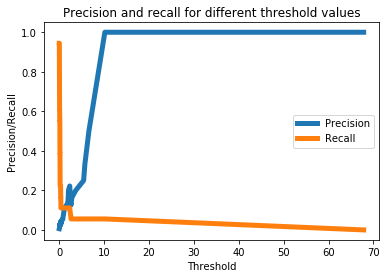

In [19]:
valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)

mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_valid['y']})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class,
                                                               error_df.Reconstruction_error)

plt.plot(threshold_rt, precision_rt[1:], label = "Precision",linewidth = 5)
plt.plot(threshold_rt, recall_rt[1:], label = "Recall",linewidth = 5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

### Perform Classification on the Test set
* use a Threshold of 0.4

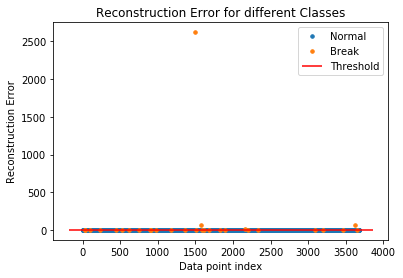

In [20]:
test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis = 1)

error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_test['y']})

error_df_test = error_df_test.reset_index()

threshold_fixed = 0.4

groups = error_df_test.groupby('True_class')

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker = 'o', ms = 3.5, linestyle = '',
            label = "Break" if name == 1 else "Normal")
    
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1],
          colors = "r", zorder = 100, label = 'Threshold')
ax.legend()

plt.title("Reconstruction Error for different Classes")
plt.ylabel("Reconstruction Error")
plt.xlabel("Data point index")
plt.show();

* Orange dots (above the line) represent True Positives
* These metrics can be better viewed with a confusion matrix

### View a Confusion Matrix for True and False Positives

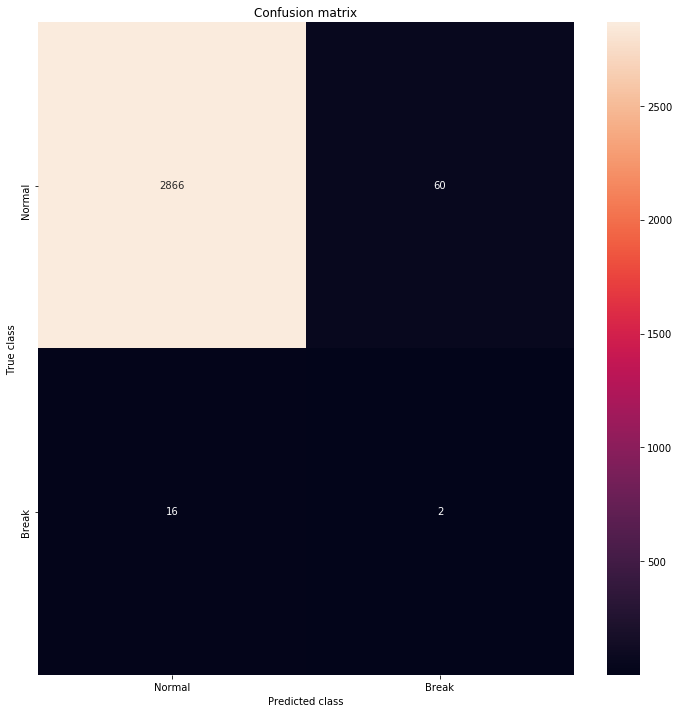

In [21]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");

plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

* Predicted 2 out of 18 (11.11 %) break instances - at 2 or 4 minutes ahead of time 

### View ROC curve and AUC
* these metrics evaluate classification models
* Receiver Operator Characteristic curve (ROC) - plots True Positive Rate (y-axis) against False Positive Rate (x-axis)
* Area Under Curve (AUC) - provids rate of successful classification

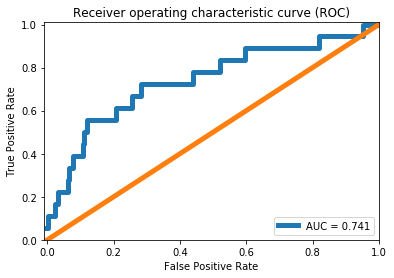

In [22]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class,
                                                      error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])

plt.legend(loc = 'lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### The AUC is 0.741 - This could be used to compare this model approach to another